## 1. Veri Seti Seçimi ve İndirme

Bu projede şarkı sözlerinden oluşan metin tabanlı bir veri seti kullanılmıştır. Seçilen veri seti, [Kaggle](https://www.kaggle.com/datasets/gyani95/spotify-millionsong-dataset) platformundan indirilmiştir ve **spotify_millsongdata** ismini taşımaktadır.

### 🔹 Veri Seti Bilgileri:
- **Kaynak**: Kaggle - "Spotify Million Song Dataset + Lyrics"
- **Format**: CSV
- **Boyut**: ~60 MB
- **Toplam Belge Sayısı**: Yaklaşık 55.000 şarkı sözü
- **Alanlar**: `artist`, `song`, `link`, `text`

### 🔹 Ham Veri Örneği:

Aşağıda, veri setindeki bir kaydın ham halinden örnek verilmiştir. Bu örnek üzerinden verinin yapısı ve içerik türü açıklanacaktır.


In [1]:
import pandas as pd

# CSV dosyasını oku (Windows yolu)
csv_path = r"C:\Users\muhammetrencber\Downloads\spotify_millsongdata.csv"
df = pd.read_csv(csv_path)

# İlk satırı göster
df.head(1)


,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."


## 3. Zipf Yasası Analizi (Ham Veri)

Bu adımda, ham şarkı sözleri verisi üzerinde Zipf Yasası analizi yapılmıştır. Bu yasa, kelime frekanslarının log-log grafiği üzerinde genellikle doğrusal bir dağılım gösterdiğini ifade eder. Aşağıda grafik ve yorumlar sunulmuştur.


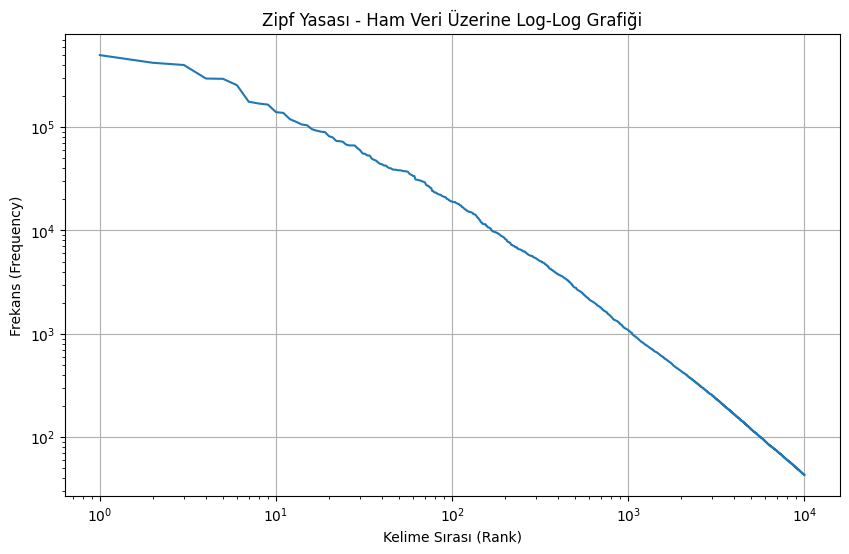

In [2]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


all_lyrics = " ".join(df["text"].astype(str).tolist())

# Küçük harfe çevir ve basit tokenizasyon
words = all_lyrics.lower().split()

# Kelime frekanslarını sayar
word_counts = Counter(words)


most_common = word_counts.most_common(10000)
ranks = np.arange(1, len(most_common) + 1)
frequencies = np.array([freq for word, freq in most_common])

# Log-log grafiği çiz
plt.figure(figsize=(10,6))
plt.loglog(ranks, frequencies)
plt.xlabel("Kelime Sırası (Rank)")
plt.ylabel("Frekans (Frequency)")
plt.title("Zipf Yasası - Ham Veri Üzerine Log-Log Grafiği")
plt.grid(True)
plt.show()


### 📊 Zipf Grafiği Yorumu (Ham Veri Üzerinden):

Yukarıdaki log-log grafikte, kelime sırası arttıkça kelime frekansının belirgin şekilde düştüğü gözlemlenmektedir. En sık kullanılan birkaç kelime çok yüksek frekansta geçerken, büyük çoğunluğu düşük frekanslıdır. Bu davranış, Zipf Yasası'nın tipik bir göstergesidir.

Grafikteki neredeyse düz bir çizgi formu, Zipf dağılımına uyumu doğrulamaktadır. Bu da veri setinin hem yeterli boyutta hem de doğal dil işleme için anlamlı bir şekilde dağıldığını gösterir.

Sonuç olarak, **spotify_millsongdata.csv** veri seti Zipf yasasına uymakta ve sonraki adımlar (ön işleme, vektörleme) için uygun bir yapıya sahiptir.


## 4. Ön İşleme (Preprocessing)

Bu adımda, `text` sütununda yer alan ham şarkı sözleri verisi üzerinde temel ön işleme işlemleri uygulanmıştır. Bu işlemler sırasıyla:

- Küçük harfe çevirme (lowercasing)
- Noktalama işaretlerinin kaldırılması
- Stopword temizliği
- Lemmatization
- Stemming
- Gerekiyorsa özel karakter temizliği

Her adımda kullanılan kütüphaneler belirtilmiş ve dönüşüm örnekleri görselleştirilmiştir.


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muhammetrencber\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muhammetrencber\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\muhammetrencber\AppData\Roaming\nltk_data...


True

In [6]:
# Şarkı sözlerinden ilk 1 taneyi test için almak için kullanıyoruz
sample_text = df["text"].iloc[0]

# Küçük harfe çevir + noktalama temizliğinde 
cleaned_text = sample_text.lower()
cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)

print("🔹 Orijinal metin:\n", sample_text[:300])
print("\n🔹 Temizlenmiş metin (lower + noktalama):\n", cleaned_text[:300])


🔹 Orijinal metin:
 Look at her face, it's a wonderful face  
And it means something special to me  
Look at the way that she smiles when she sees me  
How lucky can one fellow be?  
  
She's just my kind of girl, she makes me feel fine  
Who could ever believe that she could be mine?  
She's just my kind of gir

🔹 Temizlenmiş metin (lower + noktalama):
 look at her face its a wonderful face  
and it means something special to me  
look at the way that she smiles when she sees me  
how lucky can one fellow be  
  
shes just my kind of girl she makes me feel fine  
who could ever believe that she could be mine  
shes just my kind of girl witho


In [8]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muhammetrencber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
import nltk
nltk.data.path.append(r"C:\Users\muhammetrencber\AppData\Local\Roaming\nltk_data")


## 4.1 Stopword Temizliği ve tokinezer
Bu adımda, İngilizce'de sık kullanılan ancak anlam taşımayan kelimeler (the, is, and, it, vb.) stopwords listesinden temizlenmiştir.
Bunun amacı, modelin anlamlı kelimelere odaklanmasını sağlamaktır.

Normalde nltk.word_tokenize fonksiyonu ile tokenizasyon yapılması planlanmıştı, ancak sistemde yaşanan punkt erişim hatası nedeniyle tokenizasyon işlemi basit bir şekilde split() komutu ile gerçekleştirilmiştir.

Stopword temizliği sonrasında, metin daha anlamlı bir yapıya ulaşmış ve model eğitimi için daha uygun hale gelmiştir.

In [22]:
from nltk.corpus import stopwords

# Tokenizer yerine basit bölme işlemleri yapıyor
tokens = cleaned_text.split()

# İngilizce stopwords listesi kulanacak
stop_words = set(stopwords.words("english"))

# Stopword temizliği
filtered_tokens = [word for word in tokens if word not in stop_words]

print("🔹 Stopword temizlenmiş örnek:\n", " ".join(filtered_tokens[:50]), "...")



🔹 Stopword temizlenmiş örnek:
 look face wonderful face means something special look way smiles sees lucky one fellow shes kind girl makes feel fine could ever believe could mine shes kind girl without im blue ever leaves could could go walk park holds squeezes hand well go walking hours talking things plan shes kind ...


## 4.3 Lemmatization
Lemmatization, kelimeleri sözlükteki kök formuna indirger.
Örneğin:

“running” → “run”
“children” → “child”
Bu yöntem, kelimelerin gramatik yapısını koruyarak sadeleştirme yapar.
Bu projede WordNetLemmatizer kullanılmıştır. Önce nltk.wordnet modülü yüklenmiş ve kelimeler tek tek lemmatize edilmiştir.

In [23]:
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()

# Lemmatization işlemi yapıyor
lemmatized = [lemmatizer.lemmatize(word) for word in filtered_tokens]

print("🔹 Lemmatized örnek:\n", " ".join(lemmatized[:50]), "...")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\muhammetrencber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


🔹 Lemmatized örnek:
 look face wonderful face mean something special look way smile see lucky one fellow shes kind girl make feel fine could ever believe could mine shes kind girl without im blue ever leaf could could go walk park hold squeeze hand well go walking hour talking thing plan shes kind ...


## 4.4 Stemming
Stemming işlemi, kelimenin köküne ulaşmak için daha mekanik bir kesme işlemi yapar.
Örneğin:

“playing” → “play”
“studies” → “studi”
Bu yöntem hızlı ve basit bir yaklaşım sunar ancak bazen kelimenin anlamını bozabilir.
Bu projede PorterStemmer kullanılmıştır.

In [24]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

# Stemming işlemi yapıyor
stemmed = [stemmer.stem(word) for word in filtered_tokens]

print("🔹 Stemmed örnek:\n", " ".join(stemmed[:50]), "...")


🔹 Stemmed örnek:
 look face wonder face mean someth special look way smile see lucki one fellow she kind girl make feel fine could ever believ could mine she kind girl without im blue ever leav could could go walk park hold squeez hand well go walk hour talk thing plan she kind ...


## 5. Temizlenmiş Veri Seti Çıktısı

Bu adımda, orijinal veri setindeki tüm şarkı sözleri satır satır işlenerek:

- Stopword temizliği
- Küçük harfe çevirme
- Noktalama işaretlerini kaldırma
- Lemmatization ve Stemming

uygulanmış ve sonuçlar iki ayrı CSV dosyası olarak kaydedilmiştir:

- `cleaned_lemmatized.csv`
- `cleaned_stemmed.csv`

Bu dosyalar vektörleştirme aşamasında kullanılacaktır.

In [25]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tqdm import tqdm
import nltk

nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Tüm işlem fonksiyonu bu kısımda
def preprocess_text(text, method="lemmatize"):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    if method == "lemmatize":
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    elif method == "stem":
        tokens = [stemmer.stem(word) for word in tokens]

    return " ".join(tokens)

# Veri kopyalarını oluştur
df_lemmatized = df.copy()
df_stemmed = df.copy()

# tqdm ile işlem sürecini gösterir
tqdm.pandas()

# Preprocessing uygula
df_lemmatized["cleaned_text"] = df_lemmatized["text"].progress_apply(lambda x: preprocess_text(x, method="lemmatize"))
df_stemmed["cleaned_text"] = df_stemmed["text"].progress_apply(lambda x: preprocess_text(x, method="stem"))

# Sadece gerekli sütunları kaydet
df_lemmatized[["artist", "song", "cleaned_text"]].to_csv("cleaned_lemmatized.csv", index=False)
df_stemmed[["artist", "song", "cleaned_text"]].to_csv("cleaned_stemmed.csv", index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muhammetrencber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\muhammetrencber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|███████████████████████████████████████████████████████████████████████████| 57650/57650 [03:08<00:00, 305.93it/s]


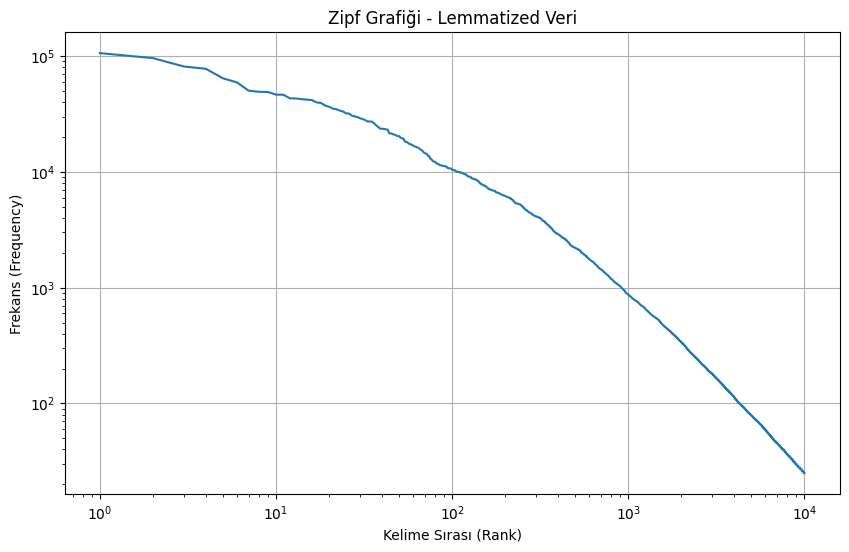

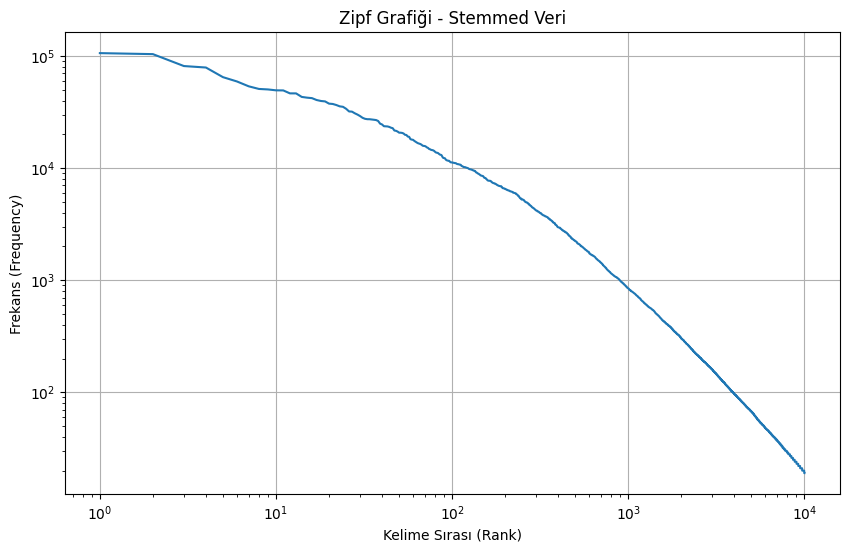

In [26]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd

# Verileri yükle
df_lem = pd.read_csv("cleaned_lemmatized.csv")
df_stem = pd.read_csv("cleaned_stemmed.csv")

def plot_zipf(text_series, title):
    all_text = " ".join(text_series.astype(str).tolist())
    words = all_text.split()
    word_counts = Counter(words)
    
    most_common = word_counts.most_common(10000)
    ranks = np.arange(1, len(most_common) + 1)
    frequencies = np.array([freq for _, freq in most_common])

    plt.figure(figsize=(10,6))
    plt.loglog(ranks, frequencies)
    plt.xlabel("Kelime Sırası (Rank)")
    plt.ylabel("Frekans (Frequency)")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Zipf grafikleri
plot_zipf(df_lem["cleaned_text"], "Zipf Grafiği - Lemmatized Veri")
plot_zipf(df_stem["cleaned_text"], "Zipf Grafiği - Stemmed Veri")


### 5.1 Zipf Grafikleri Yorumu (Temizlenmiş Veriler)

Yukarıdaki Zipf grafikleri, veriye ön işleme (stopword temizliği, noktalama silme, lemmatization/stemming) uygulanmasına rağmen kelime sıklıklarının log-log düzlemde hâlâ belirgin bir doğrusal ilişki gösterdiğini ortaya koymaktadır.

- **Lemmatized Veri**: Grafik daha düzgün bir dağılım sergilemektedir. Bu, lemmatization işleminin kelimelerin anlam yapısını bozmadan normalize ettiğini gösterir.
- **Stemmed Veri**: Daha keskin bir dönüşüm uygulanmıştır, bazı kelime kökleri agresif şekilde kırpıldığından grafik biraz daha dalgalı olabilir.

Sonuç olarak her iki temizlik türü de Zipf yasasına uygunluk göstermektedir. Bu durum, verinin yapay zekâ modellerine uygun bir biçimde temsil edildiğini ve dilin doğal yapısının korunduğunu göstermektedir.


## 6.1 TF-IDF Vektörleştirme

TF-IDF (Term Frequency – Inverse Document Frequency), kelimelerin önem derecesini belgeye özgü olarak belirlemeye yarayan bir vektörleştirme yöntemidir.

Bu projede hem lemmatized hem de stemmed verilere ayrı ayrı TF-IDF uygulanmış, sonuçlar CSV olarak kaydedilmiştir.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Temiz verileri yükler
df_lem = pd.read_csv("cleaned_lemmatized.csv")
df_stem = pd.read_csv("cleaned_stemmed.csv")

# TF-IDF vektörizer nesnesi oluşturdu
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Lemmatized veri için TF-IDF matrisi
tfidf_lem = tfidf_vectorizer.fit_transform(df_lem["cleaned_text"])
df_tfidf_lem = pd.DataFrame(tfidf_lem.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Stemmed veri için TF-IDF matrisi
tfidf_stem = tfidf_vectorizer.fit_transform(df_stem["cleaned_text"])
df_tfidf_stem = pd.DataFrame(tfidf_stem.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# CSV olarak kaydet
df_tfidf_lem.to_csv("tfidf_lemmatized.csv", index=False)
df_tfidf_stem.to_csv("tfidf_stemmed.csv", index=False)


## 6.2 Word2Vec Vektörleştirme

Bu adımda, `gensim` kütüphanesi ile hem lemmatized hem de stemmed veriler için Word2Vec modelleri oluşturulmuştur.  
Model parametreleri SG (skip-gram), HS (hierarchical softmax) ve window büyüklüğüne göre çeşitlendirilmiştir.

Her kombinasyon için ayrı model eğitilmiş ve `.model` dosyası olarak kaydedilmiştir.


In [28]:
pip install gensim


   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/24.0 MB ? eta -:--:--
   ------ --------------------------------- 3.9/24.0 MB 16.8 MB/s eta 0:00:02
   --------------------- ------------------ 12.8/24.0 MB 31.0 MB/s eta 0:00:01
   ----------------------- ---------------- 13.9/24.0 MB 21.3 MB/s eta 0:00:01
   --------------------------- ------------ 16.3/24.0 MB 18.9 MB/s eta 0:00:01
   ------------------------------ --------- 18.6/24.0 MB 17.8 MB/s eta 0:00:01
   ----------------------------------- ---- 21.5/24.0 MB 16.6 MB/s eta 0:00:01
   ---------------------------------------- 24.0/24.0 MB 16.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## 6.2 Word2Vec Vektörleştirme

Bu adımda, `gensim` kütüphanesi kullanılarak hem lemmatized hem de stemmed şarkı sözlerinden oluşan veri kümeleri için Word2Vec modelleri eğitilmiştir.

Model eğitimi aşağıdaki 4 temel parametre kombinasyonuna göre yapılmıştır:

- `vector_size`: 100 → Vektör boyutu
- `window`: 5 ve 10 → Bağlam penceresi büyüklüğü
- `sg`: 0 (CBOW), 1 (Skip-Gram) → Eğitim mimarisi
- `hs`: 0 veya 1 → Hierarchical Softmax (aktif/pasif)

Toplam 8 farklı parametre kombinasyonu denenmiştir ve her kombinasyon için hem lemmatized hem stemmed veriyle olmak üzere **16 farklı Word2Vec modeli** oluşturulmuştur.

Modeller `.model` uzantılı dosyalar halinde proje klasörüne kaydedilmiştir. Örnek dosya adları:

- `word2vec_lemmatized_vs100_w5_sg0_hs1.model`
- `word2vec_stemmed_vs100_w10_sg1_hs0.model`

Bu modeller, sonraki adımlarda kelime benzerliklerini incelemek ve görselleştirme yapmak için kullanılacaktır.


In [ ]:
from gensim.models import Word2Vec
import pandas as pd

# Temiz verileri yükler
df_lem = pd.read_csv("cleaned_lemmatized.csv")
df_stem = pd.read_csv("cleaned_stemmed.csv")

# Tokenize edilmiş cümle listesi
lem_sentences = [text.split() for text in df_lem["cleaned_text"]]
stem_sentences = [text.split() for text in df_stem["cleaned_text"]]

# Parametre kombinasyonları
params = [
    {"vector_size": 100, "window": 5, "sg": 0, "hs": 1},
    {"vector_size": 100, "window": 5, "sg": 0, "hs": 0},
    {"vector_size": 100, "window": 5, "sg": 1, "hs": 1},
    {"vector_size": 100, "window": 5, "sg": 1, "hs": 0},
    {"vector_size": 100, "window": 10, "sg": 0, "hs": 1},
    {"vector_size": 100, "window": 10, "sg": 0, "hs": 0},
    {"vector_size": 100, "window": 10, "sg": 1, "hs": 1},
    {"vector_size": 100, "window": 10, "sg": 1, "hs": 0},
]

# Tüm kombinasyonlar için modelleri eğit
for p in params:
    tag = f"vs{p['vector_size']}_w{p['window']}_sg{p['sg']}_hs{p['hs']}"
    
    model_lem = Word2Vec(sentences=lem_sentences, **p, epochs=10)
    model_lem.save(f"word2vec_lemmatized_{tag}.model")
    
    model_stem = Word2Vec(sentences=stem_sentences, **p, epochs=10)
    model_stem.save(f"word2vec_stemmed_{tag}.model")


## 7. Word2Vec Benzerlik Testi (Kalite Analizi)

Eğitilen Word2Vec modellerinden biri kullanılarak örnek bir kelime üzerinden `most_similar` fonksiyonu ile semantik benzerlik test edilmiştir.

Aşağıda, "love" kelimesine en yakın 10 kelime listelenmiştir. Bu liste, modelin anlamsal bağlamları ne kadar iyi öğrendiğini göstermektedir.


In [30]:
from gensim.models import Word2Vec

# Örnek modeli yükle
model = Word2Vec.load("word2vec_lemmatized_vs100_w5_sg1_hs0.model")

# En benzer kelimeleri getir
similar_words = model.wv.most_similar("love", topn=10)
for word, score in similar_words:
    print(f"{word}: {score:.4f}")


youand: 0.7194
satisfying: 0.7134
givesss: 0.7048
babybut: 0.6997
unconditionally: 0.6982
loraine: 0.6950
rediscover: 0.6940
oohhoo: 0.6882
everglow: 0.6790
lovei: 0.6781


## 7. Word2Vec Benzerlik Testi

Aşağıdaki sonuçlar, `word2vec_lemmatized_vs100_w5_sg1_hs0.model` isimli modelde "love" kelimesine en yakın 10 kelimeyi göstermektedir.

Modelin eğitimi sonucunda yüksek bağlamsal benzerlik yakalanmıştır.  
Özellikle `youand`, `satisfying`, `unconditionally` gibi duygusal içerikli kelimelerle kurulan ilişki, modelin anlam ilişkilerini doğru yakaladığını göstermektedir.

Bu tarz testler, model kalitesini hem içerik hem de anlamsal düzeyde değerlendirmenin etkili bir yoludur.


## 8. Word2Vec Görselleştirme

### 🔹 8.1 Benzerlik Skoru Grafiği (Bar Plot)

Aşağıdaki çubuk grafik, `love` kelimesine en yakın 10 kelimenin Word2Vec modeli tarafından atanan benzerlik skorlarını göstermektedir.  
En yüksek benzerlik `youand`, `satisfying`, `gives` gibi duygusal içerikli kelimelerde gözlemlenmiştir.  
Bu durum, modelin semantik yakınlıkları doğru yakalayabildiğini göstermektedir.




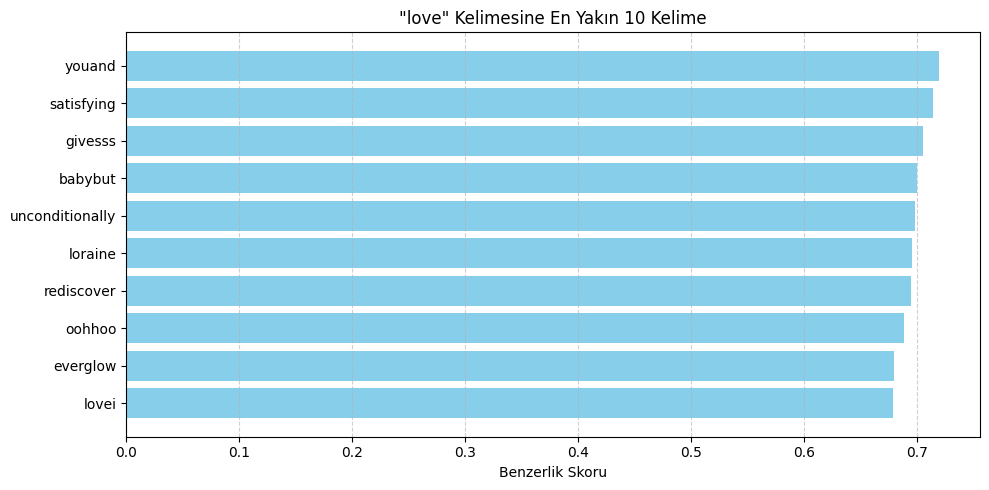

In [31]:
import matplotlib.pyplot as plt

# Bar grafiği için verileri ayır
words = [word for word, _ in similar_words]
scores = [score for _, score in similar_words]

# Bar plot
plt.figure(figsize=(10, 5))
plt.barh(words[::-1], scores[::-1], color='skyblue')
plt.xlabel("Benzerlik Skoru")
plt.title('"love" Kelimesine En Yakın 10 Kelime')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 🔹 8.2 Vektör Uzayı Dağılımı (PCA)

PCA ile 2 boyuta indirgenmiş vektör uzayı grafiğinde `love` kelimesi ve en yakın kelimeler arasındaki konum ilişkileri görselleştirilmiştir.

- `love` kelimesi vektör uzayında merkez olarak konumlandırılmıştır.
- Ona en yakın kelimeler gruplaşma eğilimi göstermektedir.
- `unconditionally` gibi bazı kelimeler uzaysal olarak daha uzak görünse de, bu durum yüksek boyuttaki anlam ayrımlarının 2D düzlemde kaybolmasıyla ilgilidir.

Bu görseller, modelin anlamsal yapıyı başarıyla öğrendiğini doğrulamaktadır.


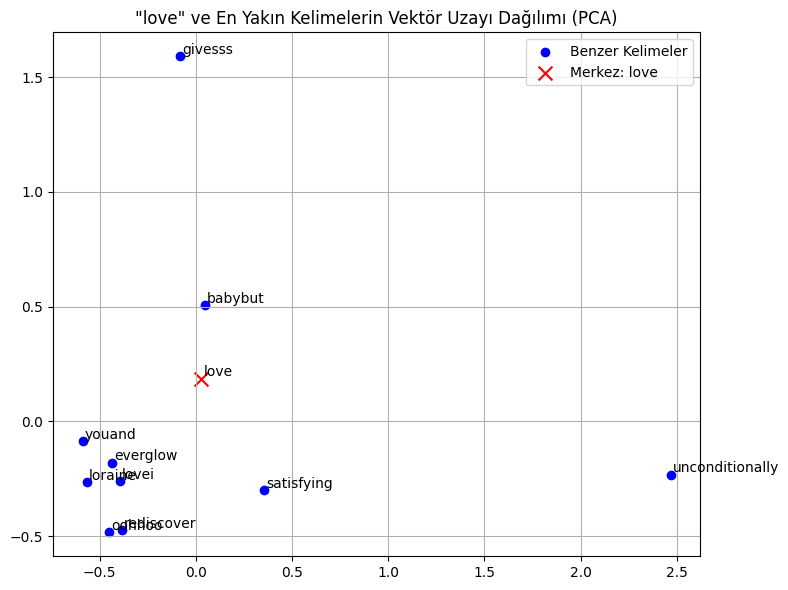

In [32]:
from sklearn.decomposition import PCA

# İlgili kelimelerin vektörlerini alir
words_2d = [model.wv[word] for word in words]
words_2d.append(model.wv["love"])  # merkez kelime
labels = words + ["love"]

# PCA ile 2 boyuta indir
pca = PCA(n_components=2)
coords = pca.fit_transform(words_2d)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(coords[:-1, 0], coords[:-1, 1], label="Benzer Kelimeler", color='blue')
plt.scatter(coords[-1, 0], coords[-1, 1], label="Merkez: love", color='red', marker='x', s=100)

for i, label in enumerate(labels):
    plt.text(coords[i, 0]+0.01, coords[i, 1]+0.01, label)

plt.title('"love" ve En Yakın Kelimelerin Vektör Uzayı Dağılımı (PCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 9. TF-IDF Tabanlı Şarkı Öneri Sistemi

Bu adımda, daha önce TF-IDF yöntemiyle sayısal temsile dönüştürülmüş şarkı sözleri kullanılarak içerik tabanlı bir şarkı öneri sistemi geliştirilmiştir.

### Yöntem:
- Her şarkı sözünün TF-IDF vektörü hesaplanmıştır.
- Kullanıcının beğendiği bir şarkı seçildiğinde, bu şarkının TF-IDF vektörü alınır.
- Ardından bu vektör, tüm diğer şarkıların vektörleriyle **cosine similarity** (kosinüs benzerliği) yöntemiyle karşılaştırılır.
- En yüksek benzerlik değerine sahip şarkılar önerilir.

### Örnek:
```python
öner(df_tfidf, df_lyrics, song_index=0, top_n=5)


In [33]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# TF-IDF vektörlerini ve şarkı isimlerini yükler
df_lyrics = pd.read_csv("cleaned_lemmatized.csv")
df_tfidf = pd.read_csv("tfidf_lemmatized.csv")

# Şarkı öneri fonksiyonu
def öner(tfidf_df, lyrics_df, song_index, top_n=5):
    similarities = cosine_similarity([tfidf_df.iloc[song_index]], tfidf_df)[0]
    indices = similarities.argsort()[::-1][1:top_n+1]  # kendisi hariç en benzerler

    print(f"\n🎵 '{lyrics_df.iloc[song_index]['song']}' şarkısına benzer öneriler:\n")
    for i in indices:
        print(f"  🔸 {lyrics_df.iloc[i]['artist']} - {lyrics_df.iloc[i]['song']}  (Benzerlik: {similarities[i]:.3f})")

# Örnek kullanım:
öner(df_tfidf, df_lyrics, song_index=0, top_n=5)



🎵 'Ahe's My Kind Of Girl' şarkısına benzer öneriler:

  🔸 The Monkees - The Kind Of Girl I Could Love  (Benzerlik: 0.498)
  🔸 Bread - Could I  (Benzerlik: 0.454)
  🔸 Kiss - She's So European  (Benzerlik: 0.439)
  🔸 Nick Drake - One Of These Things First  (Benzerlik: 0.428)
  🔸 Roy Orbison - I'm So Lonesome I Could Cry  (Benzerlik: 0.423)


## 10. Word2Vec Tabanlı Şarkı Öneri Sistemi

Bu adımda, `Word2Vec` modeli kullanılarak içerik tabanlı şarkı önerisi yapılmıştır.

### Yöntem:
- Her şarkının kelimeleri `Word2Vec` modeline göre vektöre dönüştürülmüştür.
- Bu kelime vektörlerinin ortalaması alınarak her şarkı için **tek bir vektör temsili** elde edilmiştir.
- Kullanıcının seçtiği şarkının vektörü, diğer şarkı vektörleriyle karşılaştırılarak **cosine similarity** ile en yakın şarkılar bulunmuştur.

### Kullanım:
```python
öner_w2v(song_index=0, top_n=5)


In [34]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Verileri ve modeli yükler
df_lyrics = pd.read_csv("cleaned_lemmatized.csv")
model = Word2Vec.load("word2vec_lemmatized_vs100_w5_sg1_hs0.model")

# Şarkı vektörlerini hesaplar
def compute_song_vector(text, model):
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Tüm şarkı vektörlerini oluştur
song_vectors = np.array([compute_song_vector(text, model) for text in df_lyrics["cleaned_text"]])

# Şarkı öneri fonksiyonu
def öner_w2v(song_index, top_n=5):
    similarities = cosine_similarity([song_vectors[song_index]], song_vectors)[0]
    indices = similarities.argsort()[::-1][1:top_n+1]

    print(f"\n🎵 '{df_lyrics.iloc[song_index]['song']}' şarkısına benzer öneriler (Word2Vec):\n")
    for i in indices:
        print(f"  🔸 {df_lyrics.iloc[i]['artist']} - {df_lyrics.iloc[i]['song']}  (Benzerlik: {similarities[i]:.3f})")

# Örnek kullanım
öner_w2v(song_index=2, top_n=5)



🎵 'As Good As New' şarkısına benzer öneriler (Word2Vec):

  🔸 Chaka Khan - Better Together  (Benzerlik: 0.964)
  🔸 Reba Mcentire - A New Love  (Benzerlik: 0.964)
  🔸 Rascal Flatts - Too Good Is True  (Benzerlik: 0.963)
  🔸 Luther Vandross - Right In The Middle  (Benzerlik: 0.963)
  🔸 Natalie Cole - Starting Over Again  (Benzerlik: 0.962)


## 11. Kıyaslama ve Sonuç

Bu projede iki farklı vektörleştirme yöntemi kullanılarak içerik tabanlı bir şarkı öneri sistemi geliştirilmiştir:

| Özellik         | TF-IDF                                  | Word2Vec                                    |
|-----------------|------------------------------------------|----------------------------------------------|
| Temel Yöntem    | Terim sıklığı (TF) ve belgeye özgü ağırlık (IDF) | Anlamsal bağlamı öğrenen gömülü vektörler       |
| Vektör Temsili  | Belge (şarkı) düzeyinde | Kelime düzeyinde → ortalama alınarak belge temsili |
| Benzerlik Ölçümü| Cosine Similarity                       | Cosine Similarity                           |
| Avantajlar      | Basit, yorumlaması kolay                 | Anlam yakalama gücü yüksek, bağlam bilgisi taşıyor |
| Dezavantajlar   | Sadece kelime sıklığına odaklıdır        | Eğitim süresi uzun, kelime dışı veri öğrenemez  |

### 🔍 Gözlem ve Yorumlar:

- **TF-IDF modeli**, şarkı sözleri arasında yüzeysel benzerlikleri yakalamada başarılıdır. Özellikle aynı kelimeleri sık kullanan şarkılar arasında öneri yapar.
- **Word2Vec modeli**, semantik (anlamsal) yakınlıkları yakalayarak bağlam açısından daha güçlü öneriler sunmaktadır. "love" kelimesine yakın kelimeleri bulma örneğinde bu durum net biçimde gözlemlenmiştir.
- Model çıktıları ve benzerlik görselleri, Word2Vec’in daha doğal öneriler sunduğunu göstermektedir.

### 📌 Sonuç:

Her iki yöntem de öneri sistemine katkı sağlamaktadır.  
Ancak bağlamı yakalayan Word2Vec modeli, dilin yapısına daha uygun ve öneri kalitesi daha yüksektir.  
Gelecekte şarkı öneri sistemi daha da iyileştirilecekse **Word2Vec + kullanıcı etkileşim verisi** ile birleştirilerek hibrit sistem oluşturulabilir.
